In [20]:
import os
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import pytorch_lightning as pl
from pytorch_lightning import Trainer
from pytorch_lightning.loggers import CSVLogger
from torchmetrics import Accuracy, Precision, Recall, F1Score, AUROC
from sklearn.model_selection import train_test_split
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.callbacks import EarlyStopping

import pandas as pd
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import numpy as np
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

Make a Dataloader and the Datasets.
RNADataset loads the .csv files that look like

[sequenceID],[letters],[has_pseudoknot]

sequence1,ACGUCUGU...,0

into a Dataset, encoding the letters to one-hot vectors 

A -> [1,0,0,0], C -> [0,1,0,0], G -> [0,0,1,0], U -> [0,0,0,1],
Nothing -> [0,0,0,0]

and concatenating them. 

RNADataModule will return train,val,test Dataloaders that use the RNADataset.  

I'll add a MAX_LENGTH of 500 for the sequences to help my laptop.

In [2]:
# dataset, one-hot encoding
class RNADataset(Dataset):
    def __init__(self, file_path,MAX_LENGTH=500):
        self.data = []
        self.labels = []
        self.MAX_LENGTH = MAX_LENGTH
        with open(file_path, 'r') as f:
            for line in f:
                if line.strip():
                    _,seq,label = line.strip().split(',')
                    if len(seq) > self.MAX_LENGTH: 
                        continue
                    self.data.append(self._encode_sequence(seq))
                    self.labels.append( torch.tensor( int(label) , dtype=torch.float32) )

    def _encode_sequence(self, sequence):
        """
        One-hot encoder, as follows:
        A -> [1,0,0,0], C -> [0,1,0,0], G -> [0,0,1,0], U -> [0,0,0,1]
        Nothing -> [0,0,0,0]
        """
        mapping = {'A': 0, 'C': 1, 'G': 2, 'U': 3}
        encoding = []
        for char in sequence:
            vector = [0] * 4
            if char in mapping:
                vector[mapping[char]] = 1
            encoding.append(vector)
        for _ in range(len(sequence),self.MAX_LENGTH):
            encoding.append(vector)
        return torch.flatten( torch.tensor(encoding, dtype=torch.float32) )

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

# lightning datamodule
class RNADataModule(pl.LightningDataModule):
    def __init__(self, train_file, val_file, test_file, batch_size=32):
        super().__init__()
        self.train_file = train_file
        self.val_file = val_file
        self.test_file = test_file
        self.batch_size = batch_size

    def setup(self,stage=None):
        self.train_dataset = RNADataset(self.train_file)
        self.val_dataset = RNADataset(self.val_file)
        self.test_dataset = RNADataset(self.test_file)

    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True)

    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=self.batch_size)

    def test_dataloader(self):
        return DataLoader(self.test_dataset, batch_size=self.batch_size)


First, some EDA. 

Let's look at how the train dataset looks under t-SNE.

Then, color the t-SNE according to the has_pseudoknot target.

In [3]:
dataset = RNADataset('data_splits/train.csv',500)

features = np.array([item[0].numpy() for item in dataset])
labels = np.array([item[1].numpy() for item in dataset])


In [4]:
df = pd.DataFrame(features)
df['pk'] = pd.Series(labels)
df.columns = df.columns.astype(str)
df

,0,1,2,3,4,5,6,7,8,9,...,1991,1992,1993,1994,1995,1996,1997,1998,1999,pk
0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
2,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
3,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
4,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2342,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
2343,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2344,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
2345,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0


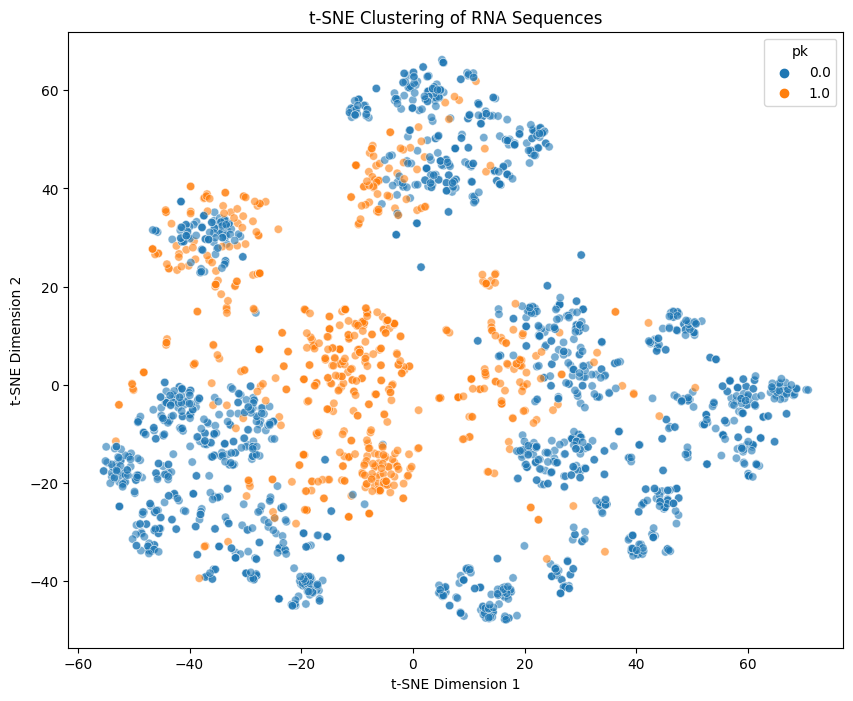

In [5]:
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
# drop 'pk' and boogie 
reduced_features = tsne.fit_transform( df.drop(columns='pk') )
df['tsne1'] = reduced_features[:, 0]
df['tsne2'] = reduced_features[:, 1]


plt.figure(figsize=(10, 8))
# plot and color by 'pk'
scatter = sns.scatterplot(x='tsne1', y='tsne2', hue='pk', data=df, alpha=0.6)
plt.title("t-SNE Clustering of RNA Sequences")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.show()


Since there is some splitting in the t-SNE projection on just 2 dimensions, I expect models to do quite well with this task. 

On to the full thing.

In [6]:
train_file = "data_splits/train.csv"
val_file = "data_splits/validation.csv"
test_file = "data_splits/test.csv"

data_module = RNADataModule(train_file, val_file, test_file, batch_size=32)
data_module.setup()

First a simple sequential model with one hidden layer.

It will look at all kinds of metrics, too.

In [7]:
# simple model
class SimpleModel(pl.LightningModule):
    def __init__(self, MAX_LENGTH=500, input_size=4, hidden_size=16, output_size=1):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size * MAX_LENGTH, hidden_size), 
            nn.ReLU(),
            nn.Linear(hidden_size, output_size),
            nn.Sigmoid()
        )
        # loss fn
        self.loss_fn = nn.BCELoss()
        # additional metrics:
        self.accuracy = Accuracy(task='binary')
        self.precision = Precision(task='binary')
        self.recall = Recall(task='binary')
        self.f1 = F1Score(task='binary')
        self.auc = AUROC(task='binary')

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x).squeeze()
        loss = self.loss_fn(y_hat, y)
        self.log('train_loss', loss)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x).squeeze()
        loss = self.loss_fn(y_hat, y)
        self.log('val_loss', loss)
        
        preds = torch.round(y_hat)
        self.log('val_accuracy', self.accuracy(preds, y))
        self.log('val_precision', self.precision(preds, y))
        self.log('val_recall', self.recall(preds, y))
        self.log('val_f1', self.f1(preds, y))
        self.log('val_auc', self.auc(y_hat, y))
        return loss

    def test_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x).squeeze()
        loss = self.loss_fn(y_hat, y)
        self.log('test_loss', loss)
        
        preds = torch.round(y_hat)
        self.log('test_accuracy', self.accuracy(preds, y))
        self.log('test_precision', self.precision(preds, y))
        self.log('test_recall', self.recall(preds, y))
        self.log('test_f1', self.f1(preds, y))
        self.log('test_auc', self.auc(y_hat, y))
        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=0.001)

Train simple model. Callbacks to go back to best on val set.

In [8]:
model = SimpleModel()

checkpoint_dir = os.path.join('logs', model.__class__.__name__)
os.makedirs(checkpoint_dir, exist_ok=True)

checkpoint_callback = ModelCheckpoint(
    monitor="val_loss",     
    mode="min",             
    save_top_k=1,       
    dirpath=checkpoint_dir,  
    filename="{epoch}-{val_loss:.2f}"
)
early_stopping = EarlyStopping(
    monitor="val_loss",
    mode="min",
    patience=5,
    verbose=True
)

csv_logger = CSVLogger("logs", name="pk_predict")

trainer = pl.Trainer(max_epochs=50,
    callbacks=[checkpoint_callback, early_stopping],
    logger=csv_logger)

trainer.fit(model, datamodule=data_module)
best_model_path = checkpoint_callback.best_model_path
print(f"Best model saved at: {best_model_path}")

best_model = model.load_from_checkpoint(best_model_path)

baseline_metrics = trainer.test(best_model, datamodule=data_module)
baseline_metrics

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/fgloblek/.pyenv/versions/3.10.8/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:617: UserWarning: Checkpoint directory /home/fgloblek/Documents/Programiranje/rna/logs/SimpleModel exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")

  | Name      | Type            | Params
----------------------------------------------
0 | model     | Sequential      | 32.0 K
1 | loss_fn   | BCELoss         | 0     
2 | accuracy  | BinaryAccuracy  | 0     
3 | precision | BinaryPrecision | 0     
4 | recall    | BinaryRecall    | 0     
5 | f1        | BinaryF1Score   | 0     
6 | auc       | BinaryAUROC     | 0     
----------------------------------------------
32.0 K    Trainable params
0         Non-trainable params
32.0 K    Total params
0.128     Total estimated model p

Sanity Checking: 0it [00:00, ?it/s]

/home/fgloblek/.pyenv/versions/3.10.8/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:438: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/fgloblek/.pyenv/versions/3.10.8/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:438: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved. New best score: 0.147


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.023 >= min_delta = 0.0. New best score: 0.124


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.016 >= min_delta = 0.0. New best score: 0.108


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.104


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.104


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 5 records. Best score: 0.104. Signaling Trainer to stop.


Best model saved at: /home/fgloblek/Documents/Programiranje/rna/logs/SimpleModel/epoch=4-val_loss=0.10.ckpt


/home/fgloblek/.pyenv/versions/3.10.8/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:438: PossibleUserWarning: The dataloader, test_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy         0.9599999785423279
        test_auc            0.9917135238647461
         test_f1            0.9199131727218628
        test_loss           0.1031188815832138
     test_precision         0.8984023928642273
       test_recall          0.9571235775947571
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.1031188815832138,
  'test_accuracy': 0.9599999785423279,
  'test_precision': 0.8984023928642273,
  'test_recall': 0.9571235775947571,
  'test_f1': 0.9199131727218628,
  'test_auc': 0.9917135238647461}]

Next do a variety of sklearn models:
- RandomForest
- Quadratic Discriminant (because it looked a bit quadratic in tsne)
- k-neighbours
- Naive Bayes
- Logistic Regression

Prepend PCA to quadratic discrimnant and log.reg to avoid collinearity.

In [31]:
def train_random_forest(X_train, y_train, X_test, y_test):
    model = RandomForestClassifier(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]
    
    results = {
        'test_accuracy': accuracy_score(y_test, y_pred),
        'test_precision': precision_score(y_test, y_pred),
        'test_recall': recall_score(y_test, y_pred),
        'test_f1': f1_score(y_test, y_pred),
        'test_auc': roc_auc_score(y_test, y_proba)
    }
    return model, results

def train_quadratic_discriminant(X_train, y_train, X_test, y_test):
    model = QuadraticDiscriminantAnalysis()
    pca = PCA(svd_solver='randomized',n_components=100) 
    X_train_pca = pca.fit_transform(X_train)
    X_test_pca = pca.transform(X_test)
    model.fit(X_train_pca, y_train)
    y_pred = model.predict(X_test_pca)
    y_proba = model.predict_proba(X_test_pca)[:, 1]
       
    results = {
        'test_accuracy': accuracy_score(y_test, y_pred),
        'test_precision': precision_score(y_test, y_pred),
        'test_recall': recall_score(y_test, y_pred),
        'test_f1': f1_score(y_test, y_pred),
        'test_auc': roc_auc_score(y_test, y_proba)
    }
    return model, results

def train_knbs(X_train, y_train, X_test, y_test):
    model = KNeighborsClassifier()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]
    
    results = {
        'test_accuracy': accuracy_score(y_test, y_pred),
        'test_precision': precision_score(y_test, y_pred),
        'test_recall': recall_score(y_test, y_pred),
        'test_f1': f1_score(y_test, y_pred),
        'test_auc': roc_auc_score(y_test, y_proba)
    }
    return model, results

def train_naive(X_train, y_train, X_test, y_test):
    model = GaussianNB()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]
    
    results = {
        'test_accuracy': accuracy_score(y_test, y_pred),
        'test_precision': precision_score(y_test, y_pred),
        'test_recall': recall_score(y_test, y_pred),
        'test_f1': f1_score(y_test, y_pred),
        'test_auc': roc_auc_score(y_test, y_proba)
    }
    return model, results

def train_logreg(X_train, y_train, X_test, y_test):
    model = LogisticRegression()
    pca = PCA(svd_solver='randomized',n_components=100) 
    X_train_pca = pca.fit_transform(X_train)
    X_test_pca = pca.transform(X_test)
    model.fit(X_train_pca, y_train)
    y_pred = model.predict(X_test_pca)
    y_proba = model.predict_proba(X_test_pca)[:, 1]
    
    results = {
        'test_accuracy': accuracy_score(y_test, y_pred),
        'test_precision': precision_score(y_test, y_pred),
        'test_recall': recall_score(y_test, y_pred),
        'test_f1': f1_score(y_test, y_pred),
        'test_auc': roc_auc_score(y_test, y_proba)
    }
    return model, results


Convert Dataloaders to sklearn friendly numpy and train.

In [32]:
def collect_data_from_dataloader(dataloader):
    """
    Convert Dataloader by iterating over it, to sklearn-friendly input.
    """
    features = []
    labels = []
    for batch in dataloader:
        x, y = batch 
        features.append(x.numpy())  
        labels.append(y.numpy())
    features = np.concatenate(features, axis=0)
    labels = np.concatenate(labels, axis=0)
    return features, labels

train_features, train_labels = collect_data_from_dataloader(data_module.train_dataloader())
val_features, val_labels = collect_data_from_dataloader(data_module.test_dataloader())

rf_model, rf_metrics = train_random_forest(train_features, train_labels, val_features, val_labels)
quaddisc_model, quaddisc_metrics = train_quadratic_discriminant(train_features, train_labels, val_features, val_labels)
kbns_model, knbs_metrics = train_knbs(train_features, train_labels, val_features, val_labels)
naive_model, naive_metrics = train_naive(train_features, train_labels, val_features, val_labels)
logreg_model, logreg_metrics = train_logreg(train_features, train_labels, val_features, val_labels)

A few more DL models.

First, a deeper net.

In [11]:
class DeeperModel(pl.LightningModule):
    def __init__(self, MAX_LENGTH=500, input_size=4, hidden_sizes=[64, 32, 16], output_size=1):
        super().__init__()
        layers = []
        in_features = input_size * MAX_LENGTH  # Assuming a max sequence length of 100
        for hidden_size in hidden_sizes:
            layers.append(nn.Linear(in_features, hidden_size))
            layers.append(nn.ReLU())
            in_features = hidden_size
        layers.append(nn.Linear(hidden_sizes[-1], output_size))
        layers.append(nn.Sigmoid())
        
        self.model = nn.Sequential(*layers)
        self.loss_fn = nn.BCELoss()
        self.accuracy = Accuracy(task='binary')
        self.precision = Precision(task='binary')
        self.recall = Recall(task='binary')
        self.f1 = F1Score(task='binary')
        self.auc = AUROC(task='binary')
    
    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x).squeeze()
        loss = self.loss_fn(y_hat, y)
        self.log('train_loss', loss, on_step=False, on_epoch=True, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x).squeeze()
        loss = self.loss_fn(y_hat, y)
        preds = torch.round(y_hat)
        self.log('val_accuracy', self.accuracy(preds, y))
        self.log('val_precision', self.precision(preds, y))
        self.log('val_recall', self.recall(preds, y))
        self.log('val_f1', self.f1(preds, y))
        self.log('val_auc', self.auc(y_hat, y))
        self.log('val_loss', loss, on_step=False, on_epoch=True, prog_bar=True)
        return loss
    
    def test_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x).squeeze()
        loss = self.loss_fn(y_hat, y)
        preds = torch.round(y_hat)
        self.log('test_accuracy', self.accuracy(preds, y))
        self.log('test_precision', self.precision(preds, y))
        self.log('test_recall', self.recall(preds, y))
        self.log('test_f1', self.f1(preds, y))
        self.log('test_auc', self.auc(y_hat, y))
        self.log('test_loss', loss)
        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=0.001)


In [12]:
model = DeeperModel()

checkpoint_dir = os.path.join('logs', model.__class__.__name__)
os.makedirs(checkpoint_dir, exist_ok=True)

checkpoint_callback = ModelCheckpoint(
    monitor="val_loss",     
    mode="min",              
    save_top_k=1,            
    dirpath=checkpoint_dir,  
    filename="{epoch}-{val_loss:.2f}" 
)
early_stopping = EarlyStopping(
    monitor="val_loss",
    mode="min",
    patience=15, 
    verbose=True
)
trainer = pl.Trainer(max_epochs=50,
    callbacks=[checkpoint_callback, early_stopping],
    logger=csv_logger)

trainer.fit(model, datamodule=data_module)
best_model_path = checkpoint_callback.best_model_path
print(f"Best model saved at: {best_model_path}")

best_model = model.load_from_checkpoint(best_model_path)

deeper_metrics = trainer.test(best_model, datamodule=data_module)
deeper_metrics

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/fgloblek/.pyenv/versions/3.10.8/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:617: UserWarning: Checkpoint directory /home/fgloblek/Documents/Programiranje/rna/logs/DeeperModel exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")

  | Name      | Type            | Params
----------------------------------------------
0 | model     | Sequential      | 130 K 
1 | loss_fn   | BCELoss         | 0     
2 | accuracy  | BinaryAccuracy  | 0     
3 | precision | BinaryPrecision | 0     
4 | recall    | BinaryRecall    | 0     
5 | f1        | BinaryF1Score   | 0     
6 | auc       | BinaryAUROC     | 0     
----------------------------------------------
130 K     Trainable params
0         Non-trainable params
130 K     Total params
0.523     Total estimated model p

Sanity Checking: 0it [00:00, ?it/s]

/home/fgloblek/.pyenv/versions/3.10.8/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:438: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/fgloblek/.pyenv/versions/3.10.8/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:438: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved. New best score: 0.135


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.034 >= min_delta = 0.0. New best score: 0.101


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 15 records. Best score: 0.101. Signaling Trainer to stop.


Best model saved at: /home/fgloblek/Documents/Programiranje/rna/logs/DeeperModel/epoch=1-val_loss=0.10-v1.ckpt


/home/fgloblek/.pyenv/versions/3.10.8/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:438: PossibleUserWarning: The dataloader, test_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy         0.9642105102539062
        test_auc            0.9922884702682495
         test_f1            0.9231372475624084
        test_loss           0.09880572557449341
     test_precision         0.9221993684768677
       test_recall          0.9436498880386353
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_accuracy': 0.9642105102539062,
  'test_precision': 0.9221993684768677,
  'test_recall': 0.9436498880386353,
  'test_f1': 0.9231372475624084,
  'test_auc': 0.9922884702682495,
  'test_loss': 0.09880572557449341}]

Next, an RNN. LSTM for better gradients.

In [13]:
class SimpleRNN(pl.LightningModule):
    def __init__(self, MAX_LENGTH=500, input_size=4, hidden_size=32, output_size=1, num_layers=1):
        super().__init__()
        
        self.hidden_size=hidden_size
        self.num_layers=num_layers
        self.lstm = nn.LSTM(
            input_size= input_size*MAX_LENGTH,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True
        )
        self.fc = nn.Sequential(
            nn.Linear(hidden_size, output_size),
            nn.Sigmoid()
        )
        self.loss_fn = nn.BCELoss()
        self.accuracy = Accuracy(task='binary')
        self.precision = Precision(task='binary')
        self.recall = Recall(task='binary')
        self.f1 = F1Score(task='binary')
        self.auc = AUROC(task='binary')

    def forward(self, x):
        out, (hn, cn) = self.lstm(x)

        out = self.fc(out)
        return out


    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x).squeeze()
        loss = self.loss_fn(y_hat, y)
        self.log('train_loss', loss)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x).squeeze()
        loss = self.loss_fn(y_hat, y)
        preds = torch.round(y_hat)
        self.log('val_accuracy', self.accuracy(preds, y))
        self.log('val_precision', self.precision(preds, y))
        self.log('val_recall', self.recall(preds, y))
        self.log('val_f1', self.f1(preds, y))
        self.log('val_auc', self.auc(y_hat, y))
        self.log('val_loss', loss)
        return loss
    
    def test_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x).squeeze()
        loss = self.loss_fn(y_hat, y)
        preds = torch.round(y_hat)
        self.log('test_accuracy', self.accuracy(preds, y))
        self.log('test_precision', self.precision(preds, y))
        self.log('test_recall', self.recall(preds, y))
        self.log('test_f1', self.f1(preds, y))
        self.log('test_auc', self.auc(y_hat, y))
        self.log('test_loss', loss)
        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=0.001)


In [14]:
model = SimpleRNN()

checkpoint_dir = os.path.join('logs', model.__class__.__name__)
os.makedirs(checkpoint_dir, exist_ok=True)

checkpoint_callback = ModelCheckpoint(
    monitor="val_loss",      
    mode="min",             
    save_top_k=1,            
    dirpath=checkpoint_dir,  
    filename="{epoch}-{val_loss:.2f}"  
)
early_stopping = EarlyStopping(
    monitor="val_loss",
    mode="min",
    patience=15,  
    verbose=True
)
trainer = pl.Trainer(max_epochs=50,
    callbacks=[checkpoint_callback, early_stopping],
    logger=csv_logger)

trainer.fit(model, datamodule=data_module)
best_model_path = checkpoint_callback.best_model_path
print(f"Best model saved at: {best_model_path}")

best_model = model.load_from_checkpoint(best_model_path)

rnn_metrics = trainer.test(best_model, datamodule=data_module)
rnn_metrics

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/fgloblek/.pyenv/versions/3.10.8/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:617: UserWarning: Checkpoint directory /home/fgloblek/Documents/Programiranje/rna/logs/SimpleRNN exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")

  | Name      | Type            | Params
----------------------------------------------
0 | lstm      | LSTM            | 260 K 
1 | fc        | Sequential      | 33    
2 | loss_fn   | BCELoss         | 0     
3 | accuracy  | BinaryAccuracy  | 0     
4 | precision | BinaryPrecision | 0     
5 | recall    | BinaryRecall    | 0     
6 | f1        | BinaryF1Score   | 0     
7 | auc       | BinaryAUROC     | 0     
----------------------------------------------
260 K     Trainable params
0         Non-trainable params
260 K     Total p

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved. New best score: 0.234


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.071 >= min_delta = 0.0. New best score: 0.163


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.028 >= min_delta = 0.0. New best score: 0.135


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.016 >= min_delta = 0.0. New best score: 0.120


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.117


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.008 >= min_delta = 0.0. New best score: 0.110


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.108


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.107


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.106


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.105


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 15 records. Best score: 0.105. Signaling Trainer to stop.


Best model saved at: /home/fgloblek/Documents/Programiranje/rna/logs/SimpleRNN/epoch=9-val_loss=0.10.ckpt


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy         0.9557894468307495
        test_auc             0.990756630897522
         test_f1            0.9162911772727966
        test_loss           0.11447514593601227
     test_precision         0.8942956924438477
       test_recall          0.9571235775947571
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_accuracy': 0.9557894468307495,
  'test_precision': 0.8942956924438477,
  'test_recall': 0.9571235775947571,
  'test_f1': 0.9162911772727966,
  'test_auc': 0.990756630897522,
  'test_loss': 0.11447514593601227}]

Finally, I think a 1d CNN might find the necessary patterns well, and would be quite lightweight. 

In [15]:
class Simple1DCNN(pl.LightningModule):
    def __init__(self, MAX_LENGTH=500, input_channels=1, output_size=1, num_filters=32, kernel_size=4*10):
        super().__init__()
        self.conv1 = nn.Conv1d(input_channels, num_filters, kernel_size, padding=0, stride=4)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool1d(kernel_size=4*2)
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.LazyLinear(output_size), 
            nn.Sigmoid()
        )
        self.loss_fn = nn.BCELoss()
        self.accuracy = Accuracy(task='binary')
        self.precision = Precision(task='binary')
        self.recall = Recall(task='binary')
        self.f1 = F1Score(task='binary')
        self.auc = AUROC(task='binary')


    def forward(self, x):
        x = x.unsqueeze(1)
        x = self.pool(self.relu(self.conv1(x)))
        return self.fc(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x).squeeze()
        loss = self.loss_fn(y_hat, y)
        self.log('train_loss', loss, on_step=False, on_epoch=True, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x).squeeze()
        loss = self.loss_fn(y_hat, y)
        preds = torch.round(y_hat)
        self.log('val_accuracy', self.accuracy(preds, y))
        self.log('val_precision', self.precision(preds, y))
        self.log('val_recall', self.recall(preds, y))
        self.log('val_f1', self.f1(preds, y))
        self.log('val_auc', self.auc(y_hat, y))
        self.log('val_loss', loss, on_step=False, on_epoch=True, prog_bar=True)
        return loss
    
    def test_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x).squeeze()
        loss = self.loss_fn(y_hat, y)
        preds = torch.round(y_hat)
        self.log('test_accuracy', self.accuracy(preds, y))
        self.log('test_precision', self.precision(preds, y))
        self.log('test_recall', self.recall(preds, y))
        self.log('test_f1', self.f1(preds, y))
        self.log('test_auc', self.auc(y_hat, y))
        self.log('test_loss', loss)
        return loss
    
    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=0.001)


In [16]:
test_batch = next(iter(data_module.train_dataloader()))
test_x,test_y = test_batch

In [17]:
model = Simple1DCNN()

checkpoint_dir = os.path.join('logs', model.__class__.__name__)
os.makedirs(checkpoint_dir, exist_ok=True)

checkpoint_callback = ModelCheckpoint(
    monitor="val_loss",      
    mode="min",             
    save_top_k=1,          
    dirpath=checkpoint_dir,
    filename="{epoch}-{val_loss:.2f}"
)
early_stopping = EarlyStopping(
    monitor="val_loss",
    mode="min",
    patience=15, 
    verbose=True
)
trainer = pl.Trainer(max_epochs=50,
    callbacks=[checkpoint_callback, early_stopping],
    logger=csv_logger)

trainer.fit(model, datamodule=data_module)
best_model_path = checkpoint_callback.best_model_path
print(f"Best model saved at: {best_model_path}")

best_model = model.load_from_checkpoint(best_model_path)

cnn_metrics = trainer.test(best_model, datamodule=data_module)
cnn_metrics

/home/fgloblek/.pyenv/versions/3.10.8/lib/python3.10/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/fgloblek/.pyenv/versions/3.10.8/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:617: UserWarning: Checkpoint directory /home/fgloblek/Documents/Programiranje/rna/logs/Simple1DCNN exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
/home/fgloblek/.pyenv/versions/3.10.8/lib/python3.10/site-packages/pytorch_lightning/utilities/model_summary/model_summary.py:415: UserWarning: A layer with UninitializedParameter was found. Thus, the total number of parameters detec

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved. New best score: 0.143


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.139


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.022 >= min_delta = 0.0. New best score: 0.118


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.008 >= min_delta = 0.0. New best score: 0.110


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.008 >= min_delta = 0.0. New best score: 0.102


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.010 >= min_delta = 0.0. New best score: 0.092


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.089


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 0.084


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.083


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 0.079


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.078


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.077


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.077


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.077


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.076


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 15 records. Best score: 0.076. Signaling Trainer to stop.


Best model saved at: /home/fgloblek/Documents/Programiranje/rna/logs/Simple1DCNN/epoch=21-val_loss=0.08.ckpt


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy         0.9810526371002197
        test_auc            0.9979708194732666
         test_f1            0.9560762047767639
        test_loss          0.053632207214832306
     test_precision         0.9624970555305481
       test_recall          0.9571235775947571
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_accuracy': 0.9810526371002197,
  'test_precision': 0.9624970555305481,
  'test_recall': 0.9571235775947571,
  'test_f1': 0.9560762047767639,
  'test_auc': 0.9979708194732666,
  'test_loss': 0.053632207214832306}]

Finally, let's view and plot the models' performance.

In [33]:
metrics = ['accuracy', 'precision', 'recall', 'f1', 'auc']

baseline_vals = [baseline_metrics[0][f'test_{m}'] for m in metrics]
deeper_vals = [deeper_metrics[0][f'test_{m}'] for m in metrics]
rnn_vals = [rnn_metrics[0][f'test_{m}'] for m in metrics]
cnn_vals = [cnn_metrics[0][f'test_{m}'] for m in metrics]
rf_vals = [rf_metrics[f'test_{m}'] for m in metrics]
quaddisc_vals = [quaddisc_metrics[f'test_{m}'] for m in metrics]
knbs_vals = [knbs_metrics[f'test_{m}'] for m in metrics]
naive_vals = [naive_metrics[f'test_{m}'] for m in metrics]
logreg_vals = [logreg_metrics[f'test_{m}'] for m in metrics]

results_df = pd.DataFrame([baseline_metrics[0],deeper_metrics[0],rnn_metrics[0],cnn_metrics[0],
              rf_metrics,quaddisc_metrics,knbs_metrics,naive_metrics,logreg_metrics
              ],
             ['1 h.layer perceptron','3 h.layer perceptron','1d CNN',
              'LSTM','RandomForest','Quad.Discriminant','kNBs','NaiveBayes','Logistic Reg.'
             ]).dropna(axis=1).sort_values(by="test_accuracy", ascending=False)
results_df.index.names = ['model']
results_df


,test_accuracy,test_precision,test_recall,test_f1,test_auc
model,,,,,
LSTM,0.981053,0.962497,0.957124,0.956076,0.997971
3 h.layer perceptron,0.964211,0.922199,0.943650,0.923137,0.992288
1 h.layer perceptron,0.960000,0.898402,0.957124,0.919913,0.991714
1d CNN,0.955789,0.894296,0.957124,0.916291,0.990757
Quad.Discriminant,0.943158,0.839161,0.967742,0.898876,0.991384
RandomForest,0.941053,0.833333,0.967742,0.895522,0.991717
kNBs,0.913684,0.927835,0.725806,0.814480,0.921492
Logistic Reg.,0.907368,0.838983,0.798387,0.818182,0.954370
NaiveBayes,0.791579,0.569061,0.830645,0.675410,0.870508


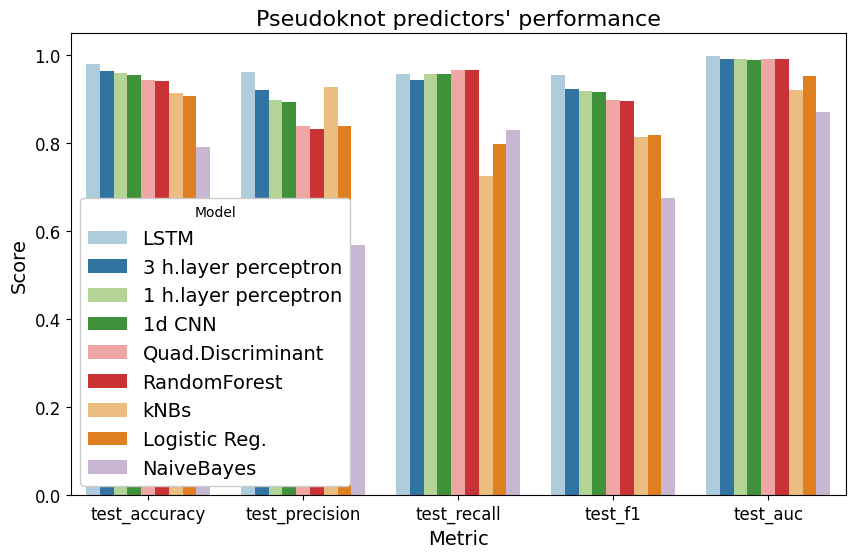

In [34]:
melted_df = pd.melt(results_df.reset_index(),id_vars='model')
    
plt.figure(figsize=(10, 6))
sns.barplot(data=melted_df, x="variable", y="value", hue="model", palette="Paired")

plt.title("Pseudoknot predictors' performance", fontsize=16)
plt.xlabel("Metric", fontsize=14)
plt.ylabel("Score", fontsize=14)
plt.ylim(0, 1.05)
plt.legend(title="Model", fontsize=14,facecolor='white', framealpha=1,frameon=True,loc='lower left')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.show()